# Exercise: General Game-Playing via Deep Reinforcement Learning

**Author**: Christian Guckelsberger (Aalto University; Queen Mary, University of London).

**Overview**: The focus of this exercise is to apply Deep Reinforcement Learning for general game-playing in a simple gridworld game. 

You learn the basics of using:
- The OpenAI Gym interface ([link](https://gym.openai.com/)). OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms and the de facto playground for reinforcement learning research. 
- The Gym-MiniGrid environment ([link](https://github.com/maximecb/gym-minigrid)), a game-like environment to be run within Gym. It is particularly simple, lightweight and fast. Gridworld environments are commonly used to test new algorithms for controlling artificial agents, e.g. a player avatar.
- State-of-the-art Reinforcement Learning algorithms from Stable Baselines 3 ([link](https://stable-baselines3.readthedocs.io/en/master/)). Stable Baselines 3 is a set of reliable implementations of reinforcement learning algorithms in PyTorch.

The notebook reuses code from Chanseok Kang / goodboychan ([source](https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-08-06-03-Policy-Gradient-With-Gym-MiniGrid.ipynb)) and Stable Baselines 3 ([source](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/stable_baselines_getting_started.ipynb#scrollTo=U29X1-B-AIKE)).

## Install Dependencies
While OpenAI Gym comes by default with Colab, the MiniGrid package and Stable Baselines 3 must be installed explicitly.

In [1]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]
!pip install gym_minigrid

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight

## Configure Basic Notebook Settings
These settings work for most parts of this exercise. You may benefit from adjusting `figure.figsize` for some modifications of the gridworld.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper Functions
The functions below allow to render a gameplay sequence in the gridworld as a video to be shown in the notebook.

In [3]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def MonitorWrapper(env):
    env = Monitor(env, './video', force=True)
    return env

# Show a video which was previously created through e.g. gym Monitor
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        print("Playing video", mp4)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## Gridworld
A gridworld is an abstract, 2d, tile-based virtual environment that is very popular in reinforcement learning research, as it affords high introspection and performance. Here, we use the **MiniGrid** Minimalistic Gridworld Environment ([link](https://github.com/maximecb/gym-minigrid)). This environment implements the **OpenAI Gym** ([https://gym.openai.com/](link)) interfaces and can thus be combined with many other state-of-the-art control algorithms.

<img src="https://i.ibb.co/kBzkC2P/minigrid6x6.png" width="200"/>

For best performance, we use one of the smallest and simplest available environments, the `MiniGrid-Empty-Random-6x6-v0`. It's a 6x6 empty room surrounded by impenetrable walls (dark grey) tiles and the player (red) position is randomly initialised in every episode. The player's goal is to reach the goal square (green). 

**Exercise 1 (explore environments)**: Load different MiniGrid environments and visualise them by executing the code in the two cells below. Check out the MiniGrid documentation for all available environments. Reset to the original code once done.

_Note_: Code comments in the form `# EXERCISE <NO>` highlight where code changes are required to complete an exercise.




In [26]:
import gym
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, FullyObsWrapper, ImgObsWrapper, RGBImgObsWrapper

env = ImgObsWrapper(FullyObsWrapper(gym.make('MiniGrid-Empty-Random-6x6-v0'))) # EXERCISE 1, EXERCISE 2, EXERCISE 5
# env = ImgObsWrapper(FullyObsWrapper(gym.make('MiniGrid-UnlockPickup-v0'))) # Solution example for EXERCISE 1
# env = ImgObsWrapper(gym.make('MiniGrid-Empty-Random-6x6-v0')) # Solution for EXERCISE 2 (partial observation)
# env = ImgObsWrapper(RGBImgObsWrapper(gym.make('MiniGrid-Empty-Random-6x6-v0'))) # Solution for EXERCISE 2/EXERCISE 5 (RGB raw pixel observation)

# Print available actions in environment
# env.action_space.n provides the total number of all actions in the environment
print("Available actions in environment:")
for action_index in range(0, env.action_space.n):
   print(action_index,":",env.actions(action_index))

# Reduce action space
# env.action_space = spaces.Discrete(3) # Solution for EXERCISE 4


Available actions in environment:
0 : Actions.left
1 : Actions.right
2 : Actions.forward
3 : Actions.pickup
4 : Actions.drop
5 : Actions.toggle
6 : Actions.done


### Interacting with the Gridworld

Any one specific gridworld environment implements a Markov Decision Process (MDP, [Wikipedia]((Wikipedia)[https://en.wikipedia.org/wiki/Markov_decision_process])), i.e. it represents a sequential decision-making problem. The code below represents one full interaction cycle with the environemnt.

<img src="https://gcdnb.pbrd.co/images/iJ7oTFXyj7gB.png?o=1" width="500"/>

As the player takes an action, the world will be changed and return an observation, a reward, and a "done" flag (not in picture).
- **Observation**: How the world looks like at this moment, top-down. A 3-dimensional matrix in the shape of the environment specifying 3 values per square denoting its RGB color. The size for the 6x6 grid is this 6x6x3.
- **Reward**: The player receives a positive reward when reaching the goal. A small negative reward is substracted from this final goal reward for each step required along the way. A scalar value, here 0 everywhere but in green square.
- **Done**: Indicating whether the goal (green square) has been reached.  Boolean, False everywhere but in green square.

_Note:_ you can ignore the grey highlighted area below. It indicates what the player would see if we assumed that they can only observe a part of the environment in their viewing direction ("_partial observability_"). For this exercise however, we assume _full observability_.

**Exercise 2 (changing observation type)**: Experiment with the MiniGrid environment wrappers to change the type of observation returned. Consult the MiniGrid documentation for information on what the various wrappers do. Can you produce a _partial observation_? Can you produce a _RGB raw pixel observation_? Reset to the original code once done.

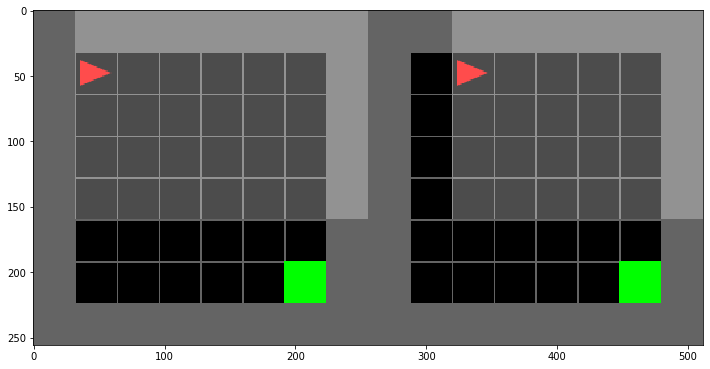

In [27]:
env.reset()
before_img = env.render('rgb_array') # render the gridworld before an action is taken
action = env.actions.forward # select "move forward" action
obs, reward, done, _ = env.step(action) # perform action on the gridlworld, thus modifying it
after_img = env.render('rgb_array') # render the gridworld again after the action was taken
plt.imshow(np.concatenate([before_img, after_img], 1)); # compare "before" and "after" renderings

In [28]:
# Show the data returned from the environment
print("Observation:", obs)
print(obs.shape)
print("Reward:", reward)
print("Done:", done)

Observation: [[[ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [10  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 1  0  0]
  [ 8  1  0]
  [ 2  5  0]]

 [[ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]
  [ 2  5  0]]]
(8, 8, 3)
Reward: 0
Done: False


## Reinforcement Learning

The goal of Reinforcement Learning is to find an optimal policy for the given MDP. In other words, we want to find a decision-rule that provides us with maximum reward in our gridworld environment. 

From Stable Baslines 3 we use:
- **Proximal Policy Optimisation (PPO)**: a state-of-the-art Reinforcement Learning algorithm to learn the policy ([docs](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html)). As an Actor-Critic method, it uses a value function to improve the policy gradient descent (by reducing the variance). It is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy. It is usually less sample efficient than off-policy alorithms like DQN, SAC or TD3, but is much faster regarding wall-clock time.
- **Multilayer Perceptron (MlpPolicy)**: a neural network function approximator for the policy with 2 layers of 64 nodes each. This typically works best with small symbolic inputs, rather than raw pixel data. Deep learning extends this network to capture more complex policies.


### Random Policy

As a benchmark for our experiment, we evaluate the performance of a player driven by a random policy through visualisation in a video and statistics. To this end, we initialise a policy but do not train it.

**Exercise 3 (initialise policy):** Initialise a MlpPolicy to be trained with PPO. Check out the PPO documentation ([link](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)) for an example.

_Note_: The cell below contains some extra code for recording a video of the gameplay resulting from sampling from the random policy. To record a video, Stable Baselines 3 requires us to wrap the environment into a vectorised environment `DummyVecEnv` which can be used for multiprocess training. This is why the sampled actions, and the return values from the environment are wrapped into arrays.



In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'
! rm -rf "video"

# Imports
import stable_baselines3
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

# Define how many steps to take / how much video to record
n_steps = 50

# Untrained, i.e. random policy
rnd_policy = None # EXERCISE 3
#rnd_policy = PPO("MlpPolicy", env, verbose=1) # Solution for EXERCISE 3

# Wrap the environment for video recording - not changing the original environment
env_vec = DummyVecEnv([lambda: env])
env_rec = VecVideoRecorder(env_vec, video_folder='video', record_video_trigger=lambda step: step == 0, video_length=n_steps, name_prefix='')

# Perform <video_length> many steps in the environment
# Thanks to the VecVideoRecorder wrapper, these steps will be automatically recorded
obs = env_rec.reset()
done = False
action_log = []
for _ in range(n_steps):
  action, _ = rnd_policy.predict(obs) # Sample next action to perform from policy
  action_log.append((action,env.actions(action).name)) # Record actions
  obs, _, done, _ = env_rec.step(action) # Take a step

env.close()

print("Reached goal: ", done)
print("Actions performed: ", action_log)

# Close the video recorder
env_rec.close()
show_video()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Saving video to /content/video/-step-0-to-step-50.mp4
Reached goal:  [False]
Actions performed:  [(array([6]), 'done'), (array([1]), 'right'), (array([1]), 'right'), (array([2]), 'forward'), (array([2]), 'forward'), (array([3]), 'pickup'), (array([0]), 'left'), (array([4]), 'drop'), (array([2]), 'forward'), (array([6]), 'done'), (array([2]), 'forward'), (array([4]), 'drop'), (array([3]), 'pickup'), (array([4]), 'drop'), (array([0]), 'left'), (array([6]), 'done'), (array([3]), 'pickup'), (array([2]), 'forward'), (array([6]), 'done'), (array([2]), 'forward'), (array([0]), 'left'), (array([6]), 'done'), (array([3]), 'pickup'), (array([0]), 'left'), (array([0]), 'left'), (array([0]), 'left'), (array([5]), 'toggle'), (array([1]), 'right'), (array([2]), 'forward'), (array([5]), 'toggle'), (array([1]), 'right'), (array([6]), 'done'), (array([5]), 'toggle'), (a

We can use the `evaluate_policy` function from Stable Baselines 3 to conveniently evaluate a policy on an environment. A mean reward of 0 means that the player has never reached the goal. Reaching a mean reward of 1 would indicate that the player has reached the goal state in every episode. However, this is very unlikely as a small negative reward will be substracted for every step they require to reach the goal tile.

**Exercise 4 (prune action space):**
- Take a note of the present performance statistics. 
- Identify uncessary actions in the actions log above ("Actions performed:")
- Determine which of the performed actions have no effect in the chosen environment by consulting the MiniGrid [documentation](https://github.com/maximecb/gym-minigrid).
- Reduce the action space given to the policy to those actions that actually have an effect in the chosen environment. To this end, you have to replace `n` in the corresponding code line. The environment will make use of the first n actions as printed earlier ("Available actions in environment:").
- Repeat the experiment, see how the change has affected the statistics. 


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Run the policy for 100 episodes
# In each episode, the player has a maximum of (4*size*size) steps to reach the goal
# I.e. in 5x5 environment, that's 100 steps to get there
mean_reward, std_reward = evaluate_policy(rnd_policy, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.4f} +/- {std_reward:.4f}")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:0.0000 +/- 0.0000


### Learned Policy

Stable Baselines 3 conveniently packages the policy learning into a single function. We train the policy for 10000 timesteps.

**Exercise 5 (CNN Policy on raw pixel data)**:
The present performance is not great, as the MlpPolicy cannot capture well spatial relationships in the grid, and is not invariant to e.g. rotation. Thus:
- Take a note of the present performance statistics.
- Switch the policy to `CnnPolicy`. Based on a Convolutional Neural Network (CNN), the policy can better capture spatial relationships in the 2D gridworld observation.
- For small environments, the default observation is too small to serve as input to the CnnPolicy. Therefore, switch the observation to raw RGB pixel data. You have learned how to choose an appropriate wrapper in Exercise 2.
- Repeat the experiment, see how the change has affected the statistics. 


In [ ]:
# Train the policy
env = ImgObsWrapper(RGBImgObsWrapper(FullyObsWrapper(gym.make('MiniGrid-Empty-Random-6x6-v0'))))
trained_policy = None # EXERCISE 3, EXERCISE 5
#trained_policy = PPO("MlpPolicy", env, verbose=1) # Solution for EXERCISE 3
#trained_policy = PPO('CnnPolicy', env, verbose=0) # Solution for EXERCISE 5
trained_policy.learn(total_timesteps=10000)

# Wrap the environment for the video recording - not changing the original environment
env_vec = DummyVecEnv([lambda: env])
env_rec = VecVideoRecorder(env_vec, video_folder='video', record_video_trigger=lambda step: step == 0, video_length=50, name_prefix='')

# Perform <video_length> many steps in the environment
# Thanks to the VecVideoRecorder wrapper, these steps will be automatically recorded
obs = env_rec.reset()
for _ in range(env_rec.video_length):
  action, _ = trained_policy.predict(obs)
  obs, _, _, _ = env_rec.step(action)

# Close the video recorder
env_rec.close()
show_video()

# Evaluate policy
mean_reward, std_reward = evaluate_policy(trained_policy, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.4f} +/- {std_reward:.4f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 115      |
|    ep_rew_mean     | 0.216    |
| time/              |          |
|    fps             | 284      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 107         |
|    ep_rew_mean          | 0.278       |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014190456 |
|    clip_fraction        | 0.138       |
|    clip_range      

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward:0.5661 +/- 0.4817


## Where to go from here?

**Well done** on completing the notebook! :-)

**Further things** you can try: 

- Train a policy on more complex MiniGrid environments. 
- Observe the effect of training a policy on environments without random initialisation. 
- Experiment with the PPO parameters or use a different learning algorithm altogether, e.g. Soft Actor Critic.
- Transfer learning: try a trained policy on other MiniGrid environments of a similar kind.
- Curriculum learning: start with a smaller environment, then update policy on larger environment.
- Explore Stable Baseline 3's extended evaluation facilities, e.g. to plot policy loss curves.
 